Angelo is able to reproduce T(E) from Smart local orbitals paper, for  lcao and C pz orbitals, not C pzd using gpaw. I am only able to reproduce lcao and not C pz. So the following analysis compares various Hamiltonians produced by me vs that produced by Angelo to find out why I am not able to reproduce C pz T(E).

In [1]:
# Necessary when connecting to a jupyterhub kernel running on daint via VScode. NOT required otherwise

import os
new_path = '/users/ajayaraj/scratch/tests/qtpyt-tests/AuBDA13'
os.chdir(new_path)


In [2]:
import pickle
from copy import deepcopy
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from gpaw import restart
from gpaw.lcao.tools import remove_pbc
from matplotlib.colors import LinearSegmentedColormap, LogNorm
from qtpyt.basis import Basis
from qtpyt.lo.tools import rotate_matrix, subdiagonalize_atoms, cutcoupling
from ase.io import read
from qtpyt.basis import Basis
from qtpyt.block_tridiag import graph_partition, greenfunction
from qtpyt.surface.principallayer import PrincipalSelfEnergy
from qtpyt.surface.tools import prepare_leads_matrices
from qtpyt.tools import remove_pbc, rotate_couplings

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [3]:
def get_species_indices(atoms,species):
    indices = []
    for element in species:
        element_indices = atoms.symbols.search(element)
        indices.extend(element_indices)
    return sorted(indices)

In [4]:
cmap_name = 'custom_white_red'
colors = [(1, 1, 1), (166/255, 4/255, 4/255)]
n_bins = 100
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)
norm = LogNorm(vmin=0.1, vmax=10)

In [5]:
GPWDEVICEDIR = 'struct2/dft/device/'
BRIDGE_SPECIES = ("N", "C", "H")
GPWLEADSDIR = 'struct2/dft/leads/'

cc_path = Path(GPWDEVICEDIR)
pl_path = Path(GPWLEADSDIR)
gpwfile = f'{cc_path}/scatt.gpw'

basis_dict = {'Au': 9, 'H': 5, 'C': 13, 'N': 13}

leads_atoms = read(pl_path / 'leads.xyz')
leads_basis = Basis.from_dictionary(leads_atoms, basis_dict)

device_atoms = read(cc_path / 'scatt.xyz')
device_basis = Basis.from_dictionary(device_atoms, basis_dict)

lowdin = True
atoms, calc = restart(gpwfile, txt=None)
fermi = calc.get_fermi_level()
nao_a = np.array([setup.nao for setup in calc.wfs.setups])
basis = Basis(atoms, nao_a)

Step 1: Compare DFT Hamiltonians from gpaw

In [21]:
ref_datafile = 'published_reference/Angelo_ase/scatt_hs_lcao.pckl'
with open(ref_datafile, 'rb') as file:
    ref_H_lcao, ref_S_lcao = pickle.load(file)

datafile = 'struct2/dft/device/hs_cc_k.pkl'
with open(datafile, 'rb') as file:
    H_lcao, S_lcao = pickle.load(file)

In [7]:
bridge_indices = get_species_indices(atoms, BRIDGE_SPECIES)
basis_bridge = basis[bridge_indices]
bridge_orbital_indices = basis_bridge.get_indices()
bridge_start = bridge_orbital_indices[0]
bridge_end = bridge_orbital_indices[-1]

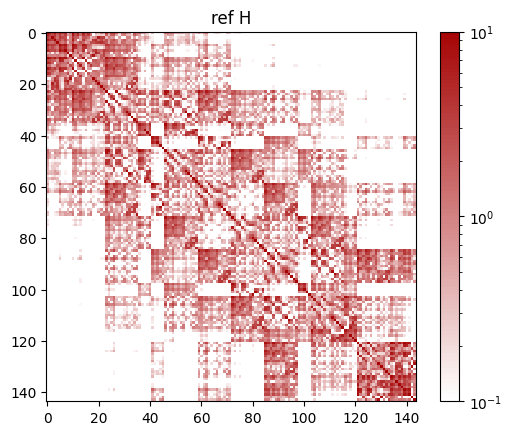

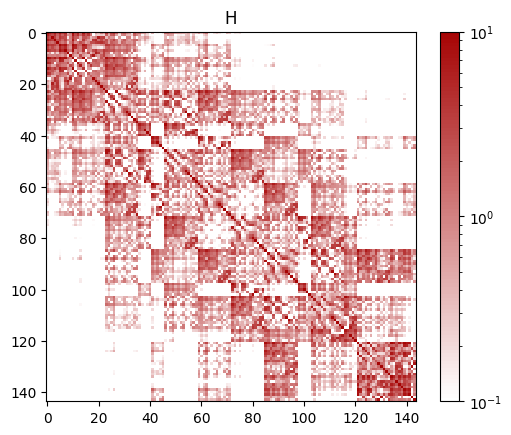

True


In [8]:
H_lcao_compare = deepcopy(H_lcao)
S_lcao_compare = deepcopy(S_lcao)


remove_pbc(device_basis, H_lcao_compare)
remove_pbc(device_basis, S_lcao_compare)

fig, ax = plt.subplots()
cax = ax.imshow(np.abs(ref_H_lcao[612:756,612:756]), interpolation='nearest', cmap=cm, norm=norm)
cbar = fig.colorbar(cax)
plt.title("ref H")
plt.show()
fig, ax = plt.subplots()
cax = ax.imshow(np.abs(H_lcao_compare[0,bridge_start:bridge_end+1,bridge_start:bridge_end+1]), interpolation='nearest', cmap=cm, norm=norm)
cbar = fig.colorbar(cax)
plt.title("H")
plt.show()
# fig, ax = plt.subplots()
# cax = ax.imshow(np.abs(H_lcao_compare[0]-ref_H_lcao))
# cbar = fig.colorbar(cax)
# plt.title("H difference")
# plt.show()
print(np.allclose(ref_H_lcao[612:756,612:756],H_lcao_compare[0,bridge_start:bridge_end+1,bridge_start:bridge_end+1],atol=0.5))

Conclusion: 
The Hamiltonians are equal within a tolerance of 0.1 eV. This difference could be due to the different versions of gpaw used.
The Efermi calculated in the two cases is slightly different. Angelo Efermi = 4.92803 eV and mine is 4.93632 eV. However, shifting both Hamiltonians by the same Efermi still keeps the equality only within a tolerance of 0.1 eV. 


Step 2:  Subdiagonalize C, N and H of Hamiltonian and compare to Angelo's subdiagonalized Hamiltonian.

In [9]:
SUBDIAG_SPECIES = ("C","N","H")
subdiag_indices = get_species_indices(atoms, SUBDIAG_SPECIES)
Usub, eig = subdiagonalize_atoms(basis, H_lcao[0], S_lcao[0], a=subdiag_indices)

x = basis.atoms.positions[:, 0]
scatt = np.where((x > 12.9) & (x < 19))[0]
basis_p = basis[scatt]
index_p = basis_p.get_indices()
for idx_lo in index_p:
    if Usub[idx_lo - 1, idx_lo] < 0.:
        Usub[:, idx_lo] *= -1

H_sub_device = rotate_matrix(H_lcao[0], Usub)
S_sub_device = rotate_matrix(S_lcao[0], Usub)

bridge_indices = get_species_indices(atoms, BRIDGE_SPECIES)
basis_bridge = basis[bridge_indices]
bridge_orbital_indices = basis_bridge.get_indices()
bridge_start = bridge_orbital_indices[0]
bridge_end = bridge_orbital_indices[-1]

[612 613 614 615 616]
[617 618 619 620 621]
[622 623 624 625 626 627 628 629 630 631 632 633 634]
[635 636 637 638 639 640 641 642 643 644 645 646 647]
[648 649 650 651 652]
[653 654 655 656 657]
[658 659 660 661 662 663 664 665 666 667 668 669 670]
[671 672 673 674 675 676 677 678 679 680 681 682 683]
[684 685 686 687 688 689 690 691 692 693 694 695 696]
[697 698 699 700 701 702 703 704 705 706 707 708 709]
[710 711 712 713 714]
[715 716 717 718 719 720 721 722 723 724 725 726 727]
[728 729 730 731 732]
[733 734 735 736 737 738 739 740 741 742 743 744 745]
[746 747 748 749 750]
[751 752 753 754 755]
[612 613 614 615 616 617 618 619 620 621 622 623 624 625 626 627 628 629
 630 631 632 633 634 635 636 637 638 639 640 641 642 643 644 645 646 647
 648 649 650 651 652 653 654 655 656 657 658 659 660 661 662 663 664 665
 666 667 668 669 670 671 672 673 674 675 676 677 678 679 680 681 682 683
 684 685 686 687 688 689 690 691 692 693 694 695 696 697 698 699 700 701
 702 703 704 705 706 707 70

In [48]:
ref_datafile = 'published_reference/Angelo_ase/scatt_hs_lcao.pckl'
with open(ref_datafile, 'rb') as file:
    ref_H_lcao, ref_S_lcao = pickle.load(file)

SUBDIAG_SPECIES = ("C","N","H")
subdiag_indices = get_species_indices(atoms, SUBDIAG_SPECIES)
Usub, eig = subdiagonalize_atoms(basis, ref_H_lcao, ref_S_lcao, a=subdiag_indices)

x = basis.atoms.positions[:, 0]
scatt = np.where((x > 12.9) & (x < 19))[0]
basis_p = basis[scatt]
index_p = basis_p.get_indices()
for idx_lo in index_p:
    if Usub[idx_lo - 1, idx_lo] < 0.:
        Usub[:, idx_lo] *= -1

H_sub_device = rotate_matrix(ref_H_lcao, Usub)
S_sub_device = rotate_matrix(ref_S_lcao, Usub)

datafile = 'published_reference/Angelo_ase/scatt_hs_sub.pckl'
with open(datafile, 'rb') as file:
    ref_H_sub, ref_S_sub = pickle.load(file)

np.allclose(np.real((ref_H_sub)),np.real((H_sub_device)),atol=30)

[612 613 614 615 616]
[617 618 619 620 621]
[622 623 624 625 626 627 628 629 630 631 632 633 634]
[635 636 637 638 639 640 641 642 643 644 645 646 647]
[648 649 650 651 652]
[653 654 655 656 657]
[658 659 660 661 662 663 664 665 666 667 668 669 670]
[671 672 673 674 675 676 677 678 679 680 681 682 683]
[684 685 686 687 688 689 690 691 692 693 694 695 696]
[697 698 699 700 701 702 703 704 705 706 707 708 709]
[710 711 712 713 714]
[715 716 717 718 719 720 721 722 723 724 725 726 727]
[728 729 730 731 732]
[733 734 735 736 737 738 739 740 741 742 743 744 745]
[746 747 748 749 750]
[751 752 753 754 755]


True

In [56]:
datafile = 'published_reference/Angelo_ase/different_eig/scatt_hs_sub.pckl'
with open(datafile, 'rb') as file:
    ref_H_sub2, ref_S_sub2 = pickle.load(file)

np.allclose(np.real((ref_H_sub2)),np.real((H_sub_device)),atol=10)

False

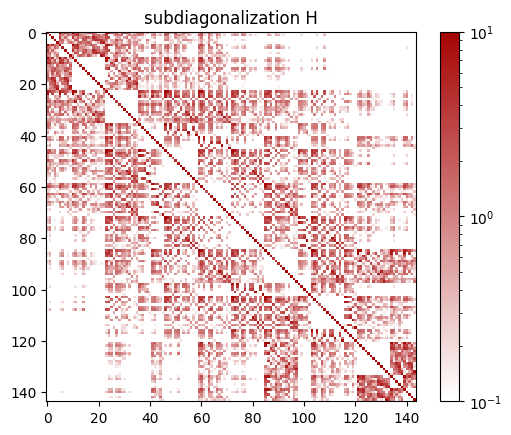

In [35]:
bridge_region_H_sub = H_sub_device[bridge_start:bridge_end+1,bridge_start:bridge_end+1]
bridge_region_S_sub = S_sub_device[bridge_start:bridge_end+1,bridge_start:bridge_end+1]
fig, ax = plt.subplots()
cax = ax.imshow(np.abs(bridge_region_H_sub), interpolation='nearest', cmap=cm, norm=norm)
cbar = fig.colorbar(cax)
plt.title("subdiagonalization H")
plt.show()

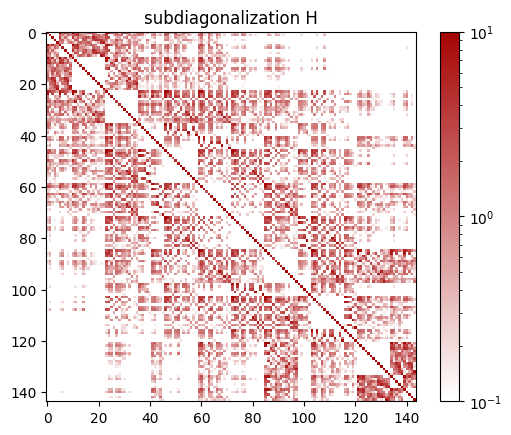

In [36]:
bridge_region_H_sub_ref = ref_H_sub[bridge_start:bridge_end+1,bridge_start:bridge_end+1]
fig, ax = plt.subplots()
cax = ax.imshow(np.abs(bridge_region_H_sub_ref), interpolation='nearest', cmap=cm, norm=norm)
cbar = fig.colorbar(cax)
plt.title("subdiagonalization H")
plt.show()

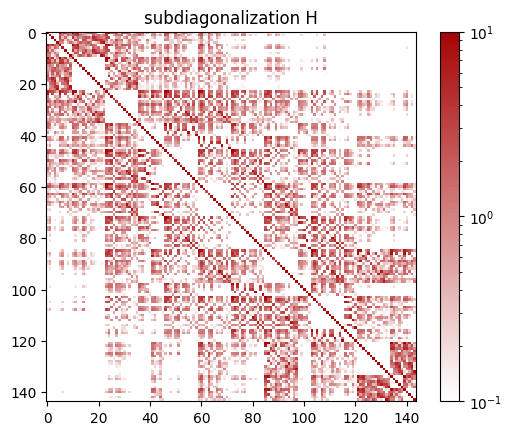

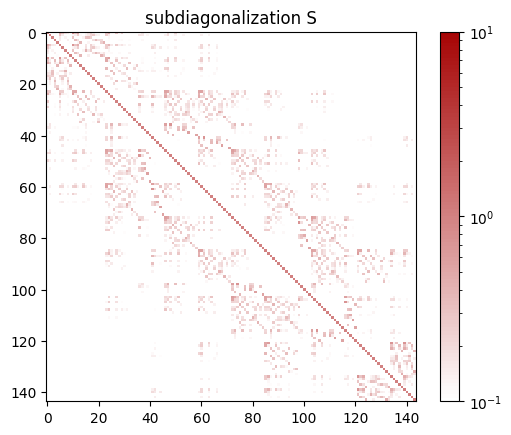

In [10]:
bridge_region_H_sub = H_sub_device[bridge_start:bridge_end+1,bridge_start:bridge_end+1]
bridge_region_S_sub = S_sub_device[bridge_start:bridge_end+1,bridge_start:bridge_end+1]
fig, ax = plt.subplots()
cax = ax.imshow(np.abs(bridge_region_H_sub), interpolation='nearest', cmap=cm, norm=norm)
cbar = fig.colorbar(cax)
plt.title("subdiagonalization H")
plt.show()

fig, ax = plt.subplots()
cax = ax.imshow(np.abs(bridge_region_S_sub), interpolation='nearest', cmap=cm, norm=norm)
cbar = fig.colorbar(cax)
plt.title("subdiagonalization S")
plt.show()

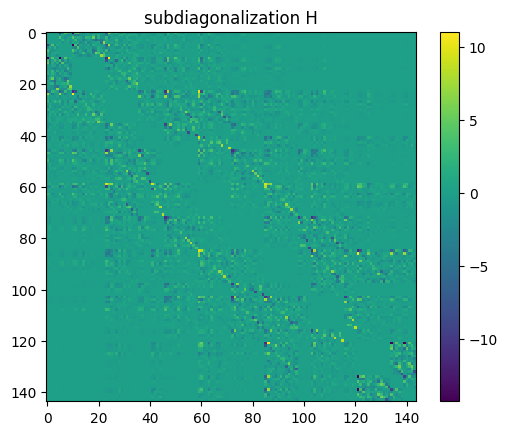

In [11]:
bridge_region_H_sub = H_sub_device[bridge_start:bridge_end+1,bridge_start:bridge_end+1]
bridge_region_S_sub = S_sub_device[bridge_start:bridge_end+1,bridge_start:bridge_end+1]
fig, ax = plt.subplots()
diag_H = np.diag(np.diag(bridge_region_H_sub))
cax = ax.imshow((bridge_region_H_sub-diag_H), interpolation='nearest')#, cmap=cm, norm=norm)
cbar = fig.colorbar(cax)
plt.title("subdiagonalization H")
plt.show()


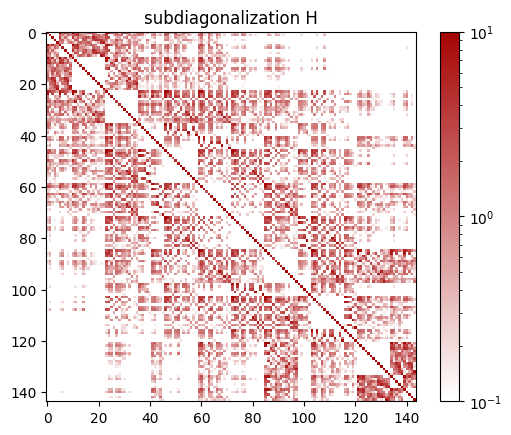

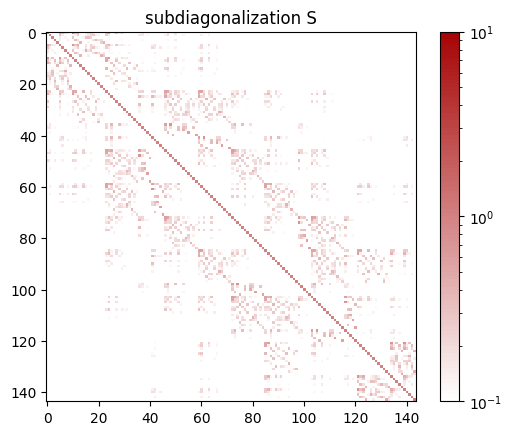

In [12]:
datafile = 'published_reference/Angelo_ase/scatt_hs_sub.pckl'
with open(datafile, 'rb') as file:
    ref_H_sub, ref_S_sub = pickle.load(file)

bridge_region_H_sub_ref = ref_H_sub[612:756,612:756]
bridge_region_S_sub_ref = ref_S_sub[612:756,612:756]
fig, ax = plt.subplots()
cax = ax.imshow(np.abs(bridge_region_H_sub_ref), interpolation='nearest', cmap=cm, norm=norm)
cbar = fig.colorbar(cax)
plt.title("subdiagonalization H")
plt.show()

fig, ax = plt.subplots()
cax = ax.imshow(np.abs(bridge_region_S_sub_ref), interpolation='nearest', cmap=cm, norm=norm)
cbar = fig.colorbar(cax)
plt.title("subdiagonalization S")
plt.show()

In [20]:
np.allclose(ref_H_sub,H_sub_device,atol=30)

True

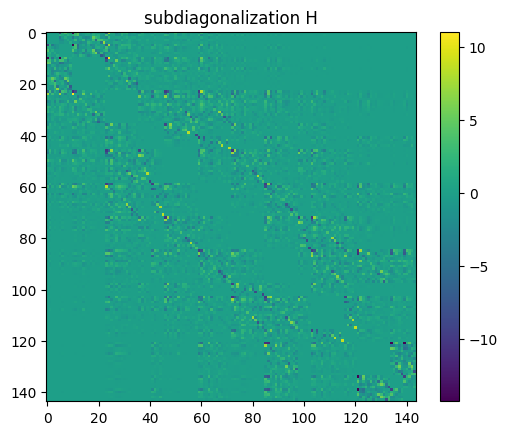

In [13]:
bridge_region_H_sub_ref = ref_H_sub[612:756,612:756]
fig, ax = plt.subplots()
diag_H_ref = np.diag(np.diag(bridge_region_H_sub_ref))
cax = ax.imshow(np.real(bridge_region_H_sub_ref-diag_H_ref), interpolation='nearest')#, cmap=cm, norm=norm)
cbar = fig.colorbar(cax)
plt.title("subdiagonalization H")
plt.show()


False


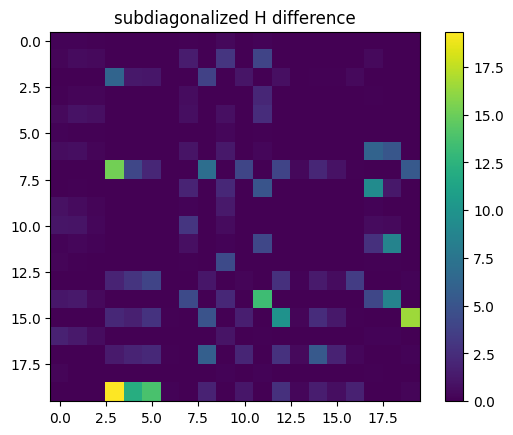

In [15]:
print(np.allclose(bridge_region_H_sub_ref[40:60,20:40],bridge_region_H_sub[40:60,20:40],atol=1e-1))
fig, ax = plt.subplots()
cax = ax.imshow(np.abs(bridge_region_H_sub_ref[40:60,20:40]-bridge_region_H_sub[40:60,20:40]))
cbar = fig.colorbar(cax)
plt.title("subdiagonalized H difference")
plt.show()

In [82]:
np.allclose(np.diag(bridge_region_H_sub_ref),np.diag(bridge_region_H_sub))

False

In [81]:
np.diag(bridge_region_H_sub)

array([-11.79681751,   6.51260326,  14.21159817,  20.01678031,
        20.21028687, -11.81299968,   6.464438  ,  14.10037237,
        19.92672813,  20.20549393, -18.88885109,  -9.32508668,
        -8.38071532,  -4.90891172,   9.16401041,  11.78701673,
        12.94790685,  18.91297929,  29.48832938,  30.57033412,
        34.26103837,  34.96740268,  35.09692089, -15.91991343,
       -11.39014726,  -9.92666082,  -3.25476577,   3.68087137,
         4.80733428,  11.19935273,  11.47109149,  17.39030572,
        18.00982843,  23.95978481,  24.09131491,  24.1909433 ,
        -8.82450817,   7.83060403,  16.71637214,  21.4360226 ,
        21.63258763,  -9.31350919,   7.09733795,  16.22086319,
        20.86276518,  21.18842389, -14.82725057,  -9.5419588 ,
        -7.38120484,  -2.30298447,   5.31492303,   6.94622604,
        12.32078962,  13.99583794,  18.73608776,  19.95921017,
        24.59072472,  24.95733061,  25.98623824, -15.07093445,
       -10.19430883,  -7.72168271,  -2.5413603 ,   4.47

In [56]:
def find_top_n_differences(bridge_region_H_sub_ref, bridge_region_H_sub, n):
    difference = np.abs(bridge_region_H_sub_ref[40:60, 20:40] - bridge_region_H_sub[40:60, 20:40])

    top_n_indices_flat = np.argpartition(difference.flatten(), -n)[-n:]

    top_n_indices_flat = top_n_indices_flat[np.argsort(difference.flatten()[top_n_indices_flat])][::-1]

    top_n_indices_2d = np.unravel_index(top_n_indices_flat, difference.shape)

    global_top_n_indices = [(i + 40, j + 20) for i, j in zip(*top_n_indices_2d)]

    print(f'Top {n} maximum differences and their indices:')
    for i in range(n):
        diff_value = difference[top_n_indices_2d][i]
        global_index = global_top_n_indices[i]
        value_ref = bridge_region_H_sub_ref[global_index[0], global_index[1]]
        value_sub = bridge_region_H_sub[global_index[0], global_index[1]]
        print(f'Maximum difference {i+1}: {diff_value}, Global index: {global_index}')
        print(f'Value in bridge_region_H_sub_ref: {value_ref}')
        print(f'Value in bridge_region_H_sub: {value_sub}')
        print()
n=5
find_top_n_differences(bridge_region_H_sub_ref, bridge_region_H_sub, n)


Top 5 maximum differences and their indices:
Maximum difference 1: 19.338341791221445, Global index: (59, 23)
Value in bridge_region_H_sub_ref: (-9.652988923068966+0j)
Value in bridge_region_H_sub: 9.685352868152481

Maximum difference 2: 15.256606675080754, Global index: (47, 23)
Value in bridge_region_H_sub_ref: (-7.614323886608188+0j)
Value in bridge_region_H_sub: 7.642282788472565

Maximum difference 3: 14.002967926506884, Global index: (46, 25)
Value in bridge_region_H_sub_ref: (6.9860020138989105+0j)
Value in bridge_region_H_sub: -7.016965912607973

Maximum difference 4: 13.327894796030101, Global index: (54, 31)
Value in bridge_region_H_sub_ref: (-6.674871342708791+0j)
Value in bridge_region_H_sub: 6.653023453321311

Maximum difference 5: 13.080487210492896, Global index: (48, 36)
Value in bridge_region_H_sub_ref: (6.520426281182045+0j)
Value in bridge_region_H_sub: -6.5600609293108505

